<a href="https://colab.research.google.com/github/SaashaJoshi/pennylane-demo-cern/blob/main/1_classical_ml_with_automatic_differentiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
%%capture 

# Comment this out if you don't want to install pennylane from this notebook
!pip install pennylane

# Comment this out if you don't want to install matplotlib from this notebook
!pip install matplotlib

# Training a machine learning model with automatic differentiation

In this tutorial we will: 

* implement a toy version of a typical machine learning setup,
* understand how automatic differentiation allows us to compute gradients of the machine learning model, and
* use automatic differentiation to train the model.

First some imports...

In [19]:
import pennylane as qml
from pennylane import numpy as np # This will import a special, "differentiable" version of numpy.

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

In [20]:
np.array([0.1, -0.9])    # This is a tensor array with gradient

tensor([ 0.1, -0.9], requires_grad=True)

In [21]:
import numpy as vanilla_np

vanilla_np.array([0.1, -0.9])

array([ 0.1, -0.9])

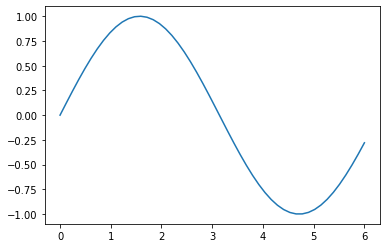

In [22]:
x_axis = np.linspace(0, 6)
function_sin = np.sin(x_axis)

plt.plot(x_axis, function_sin)

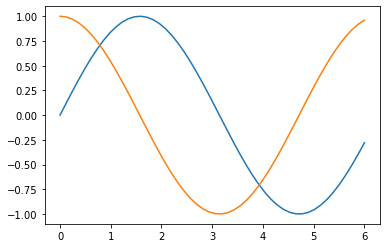

In [23]:
# We can find the gradient of the above function too. 
# In a vanilla numpy version, we cannot differentiate!

gradient_fnc = qml.grad(np.sin, argnum = 0)

g = [gradient_fnc(x) for x in x_axis]

plt.plot(x_axis, function_sin)
plt.plot(x_axis, g)

## 1. The three basic ingredients

A machine learning problem usually consists of *data*, a *model (family)* and a *cost function*: 

<br />
<img src="https://github.com/XanaduAI/pennylane-demo-cern/blob/main/figures/data-model-cost.png?raw=1" width="500">
<br />

*Training* selects the best model from the family by minimising the cost on a training set of data samples. If we design the optimisation problem well, the trained model will also have a low cost on new sets of data samples that have not been used in training. This means that the model *generalises* well. 

We will now create examples for each ingredient.

### Data

Let us create a two-dimensional toy dataset.

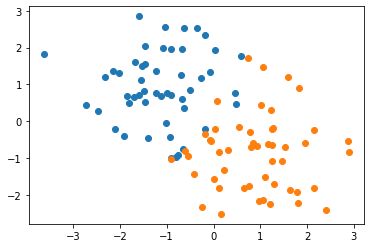

In [24]:
n_samples = 100
X0 = np.array([[np.random.normal(loc=-1, scale=1), 
                np.random.normal(loc=1, scale=1)] for i in range(n_samples//2)]) 
X1 = np.array([[np.random.normal(loc=1, scale=1), 
                np.random.normal(loc=-1, scale=1)] for i in range(n_samples//2)]) 
X = np.concatenate([X0, X1], axis=0)    # Concatenate both X0 and X1 into a single tensor.
Y = np.concatenate([-np.ones(50), np.ones(50)], axis=0)
data = list(zip(X, Y))


plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])
plt.show()

In [25]:
X.shape

(100, 2)

### Model family

Next, we construct a linear model.

In [26]:
def model(x, w):
    return np.dot(x, w)

Let's try it out.

In [10]:
w = np.array([-0.5, -0.2])

model(X0[0], w)
# model(X0[1], w)

# If we put a threshold at zero (0), X0[0] would be classified in class +1 and X0[1] will be classified in class -1

0.07929578372862058

We can plot the decision boundary, or the boundary in data space where the model flips from a negative to a positive prediction

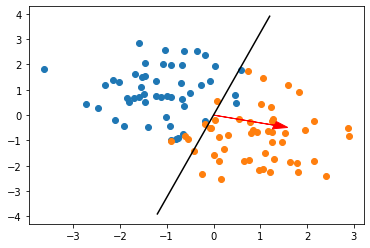

In [27]:
plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])

plt.arrow(0, 0, w[0], w[1], head_width=0.3, head_length=0.3, fc='r', ec='r')
plt.plot([-3*w[1], 3*w[1]], [3*w[0], -3*w[0]], 'k-')
plt.show()

### Cost function

How good is the model on a single input-output training pair?

In [28]:
def loss(a, b):
    return (a - b)**2    # Square of difference.

What is the average loss on a data set of multiple pairs?

In [29]:
def average_loss(w, data):
    c = 0
    for x, y in data:
        prediction = model(x, w)
        c += loss(prediction, y)
    return c/len(data)

In [30]:
w = np.array([1.3, -0.4])
average_loss(w, data)

1.8504767821580002

## 2. Automatic computation of  gradients

Because we imported PennyLane's numpy version, we can now compute gradients of the average loss with respect to the weights!

In [31]:
gradient_fn = qml.grad(average_loss, argnum=0)
gradient_fn(w, data)

array([ 3.29902953, -1.94918243])

We can use gradients to guess better candidates for parameters.

In [32]:
w_new = w - 0.05*gradient_fn(w, data)

In [33]:
average_loss(w_new, data)

1.2102626825705949

This works because the gradient always points towards the steepest ascent in the cost landscape.

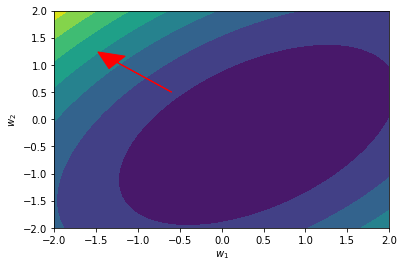

In [34]:
# compute the gradient at some point in parameter space
some_w = np.array([-0.6, 0.5])
g = 0.01*gradient_fn(some_w, data)
# learning rate = 0.01 here above!

# make a contourplot of the cost
w1s = np.linspace(-2, 2)
w2s = np.linspace(-2, 2)
cost_grid = []
for w1 in w1s:
    for w2 in w2s:
        w = np.array([w1, w2])
        cost_grid.append(average_loss(w, data))
cost_grid = np.array(cost_grid).reshape((50, 50))
plt.contourf(w1s, w2s, cost_grid.T)

plt.arrow(some_w[0], some_w[1], some_w[0] + g[0], some_w[1] + g[1], 
          head_width=0.3, head_length=0.3, fc='r', ec='r')
plt.xlabel(r"$w_1$")
plt.ylabel(r"$w_2$")
plt.show()

## 3. Training with gradient descent

Putting it all together, we can train the linear model.

In [35]:
w_init = np.random.random(size=(2,))
w = np.array(w_init)

history = []
for i in range(15):
    w_new = w - 0.05*gradient_fn(w, data)
    print(average_loss(w_new, data))
    history.append(w_new)
    w = w_new

1.3500100407100541
1.102185220934838
0.9290184060813585
0.8027576735134763
0.7073372523673335
0.6331673539752455
0.5743007976098509
0.5268826928791955
0.488294380852497
0.45667438524266574
0.4306452071742513
0.4091534224361
0.3913728909446769
0.376643727003794
0.3644320177904416


We can easily visualise the path that gradient descent took in parameter space.

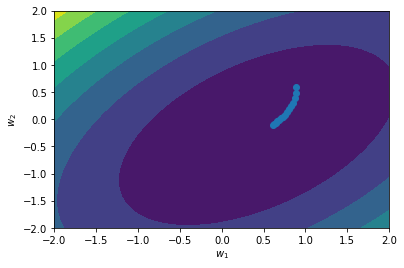

In [36]:
plt.contourf(w1s, w2s, cost_grid.T)
history = np.array(history)
plt.plot(history[:, 0], history[:, 1], "-o")
plt.xlabel(r"$w_1$")
plt.ylabel(r"$w_2$")
plt.show()

Training didn't fully converge yet, but the decision boundary is already better.

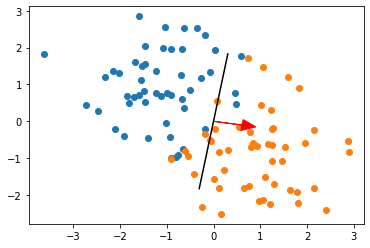

In [37]:
plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])

plt.arrow(0, 0, w[0], w[1], head_width=0.3, head_length=0.3, fc='r', ec='r')
plt.plot([-3*w[1], 3*w[1]], [3*w[0], -3*w[0]], 'k-')
plt.show()

# TASKS 



1. Add a constant scalar bias term $b \in \mathbb{R}$ to the model,

    $$ f(x, w) = \langle w, x \rangle + b, $$

   and train both $w$ and $b$ at the same time.
   

2. Change the model to a neural network with a single hidden layer.

    $$ f(x, w, W) = \langle w, \varphi(Wx) \rangle,$$

   where $W$ is a weight matrix of suitable dimension and $\varphi$ a hand-coded nonlinar activation function. 
   
   Tipp: You can use the vector-valued sigmoid function 
   
   ```
   def sigmoid(z):
        return 1/(1 + np.exp(-x))
   ```
   

3. Code up the above example using PyTorch.

In [ ]:
n_samples = 100
X0 = np.array([[np.random.normal(loc=-1, scale=1), 
                np.random.normal(loc=1, scale=1)] for i in range(n_samples//2)]) 
X1 = np.array([[np.random.normal(loc=1, scale=1), 
                np.random.normal(loc=-1, scale=1)] for i in range(n_samples//2)]) 
X = np.concatenate([X0, X1], axis=0)    # Concatenate both X0 and X1 into a single tensor.
Y = np.concatenate([-np.ones(50), np.ones(50)], axis=0)
data = list(zip(X, Y))


plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])
plt.show()

In [39]:
samples = 100

# Class 1
X_1 = np.array([[np.random.normal, np.random.normal] for i in range(samples//2)])

# Class 2
X_2 = np.array([[np.random.normal, np.random.normal] for i in range(samples//2)])

# Bias
bias = np.array([n.random.normal] for i in range(samples))

X = np.concatenate([X_1, X_2], axis = 0)
X_data = np.add(X, bias)

Y_class_data = np.concatenate([-np.ones(50), np.ones(50)], axis = 0)

data = list(zip(X_data, Y_class_data))

print(X_data)

TypeError: ignored